# Pre-Processing

*This code imports the necessary libraries, and uploads all the necessary data files.*

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from operator import itemgetter

stopwords_eng = stopwords.words('english')

from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\linhv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\linhv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
chunk0 = pd.read_csv(r"C:\Users\linhv\data science\data\chunk_00000.csv.gz")
chunk1 = pd.read_csv(r"C:\Users\linhv\data science\data\chunk_00001.csv.gz")
chunk2 = pd.read_csv(r"C:\Users\linhv\data science\data\chunk_00002.csv.gz")
chunk3 = pd.read_csv(r"C:\Users\linhv\data science\data\chunk_00003.csv.gz")
chunk4 = pd.read_csv(r"C:\Users\linhv\data science\data\chunk_00004.csv.gz")
chunk5 = pd.read_csv(r"C:\Users\linhv\data science\data\chunk_00005.csv.gz")

bonds = pd.read_csv(r"C:\Users\linhv\data science\data\bonds.csv")
users = pd.read_csv(r"C:\Users\linhv\data science\data\info_users.csv", sep=';')

*This code converts Unix timestamps in the date column of each chunk from seconds to a readable datetime format.*

In [3]:
# Convert date in chunks from seconds to date-time

chunk0['date'] = pd.to_datetime(chunk0['date'], unit='s')
chunk1['date'] = pd.to_datetime(chunk1['date'], unit='s')
chunk2['date'] = pd.to_datetime(chunk2['date'], unit='s')
chunk3['date'] = pd.to_datetime(chunk3['date'], unit='s')
chunk4['date'] = pd.to_datetime(chunk4['date'], unit='s')
chunk5['date'] = pd.to_datetime(chunk5['date'], unit='s')


*This block checks each chunk for missing values.*

In [4]:
#check for null value
print(chunk0.isnull().any(), '\n')
print(chunk1.isnull().any(), '\n')
print(chunk2.isnull().any(), '\n')
print(chunk3.isnull().any(), '\n')
print(chunk4.isnull().any(), '\n')

tweet_id       False
user_id        False
text           False
date           False
anxiety        False
anger          False
sadness        False
nb_original    False
nb_answer      False
nb_retweet     False
dtype: bool 

tweet_id       False
user_id        False
text           False
date           False
anxiety        False
anger          False
sadness        False
nb_original    False
nb_answer      False
nb_retweet     False
dtype: bool 

tweet_id       False
user_id        False
text           False
date           False
anxiety        False
anger          False
sadness        False
nb_original    False
nb_answer      False
nb_retweet     False
dtype: bool 

tweet_id       False
user_id        False
text           False
date           False
anxiety        False
anger          False
sadness        False
nb_original    False
nb_answer      False
nb_retweet     False
dtype: bool 

tweet_id       False
user_id        False
text           False
date           False
anxiety        False

For each chunk, the output is a series with column names as the index and True or False as values, indicating whether a column has missing values. The output shows False for all column in each chunk, meaning there are no missing values.

*Concatenates all the chunks into a single DataFrame tweets_raw. Then, it provides an overview of the combined DataFrame and confirms that there are no missing values.*

In [5]:
# Combine chunks0 to 5
tweets_raw = pd.concat([chunk0, chunk1, chunk2, chunk3, chunk4, chunk5], ignore_index=True)

print(tweets_raw.info(), "\n")
print(f"Are there any null values?\n\n{tweets_raw.isnull().any()}")
has_nas = tweets_raw.isna().any().any()
print(f"Are there any NA values? {has_nas}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165449 entries, 0 to 3165448
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   tweet_id     int64         
 1   user_id      int64         
 2   text         object        
 3   date         datetime64[ns]
 4   anxiety      float64       
 5   anger        float64       
 6   sadness      float64       
 7   nb_original  float64       
 8   nb_answer    float64       
 9   nb_retweet   float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 241.5+ MB
None 

Are there any null values?

tweet_id       False
user_id        False
text           False
date           False
anxiety        False
anger          False
sadness        False
nb_original    False
nb_answer      False
nb_retweet     False
dtype: bool
Are there any NA values? False


The output above indicates the structure of the DataFrame: column names, data types, and non-null counts for each column. The data types are in line with what we expect, with everything being a numerical value (either int64 or float64), except for "text" which is a string (object), and "date" which is of type datetime64. There are also no missing values, as expected.

# Cleaning Twitter Data

## Duplicates

*This block identifies and counts rows in tweets_raw that are duplicates across all columns, and prints the results. We specifically looked for duplicates across all columns (rather than any columns) because the nature of twitter data allows for duplicate tweets and duplicate users, which we do not want to remove.*

In [6]:
print(f"Are there any duplicates across all columns? {tweets_raw.duplicated().any()}")

# Identify all duplicates
num_duplicates = tweets_raw.duplicated(keep=False).sum()

print(f"Number of duplicate rows across all columns: {num_duplicates}")

Are there any duplicates across all columns? True
Number of duplicate rows across all columns: 1077140


The output indicates that there are 1077140 rows that are duplicates across all columns. These are rows we can remove from the data.

*This block sorts the DataFrame by date in ascending order prior to dropping duplicates. The (keep='first') argument ensures the first occurrence of the duplicates are kept, which is the earliest occurrence due to the sorting. Then, we summarize the procedure by identifying the shape of the DataFrame after dropping, checking for any remaining duplicates, and identifying the number removed.*

In [7]:
# Sort the DataFrame by date-time in ascending order to keep the earliest entry
tweets_raw = tweets_raw.sort_values(by='date', ascending=True)

# Drop duplicates that are identical across all columns, keeping the first (earliest) occurrence
tweets_no_dup = tweets_raw.drop_duplicates(keep='first')

# Reset the index
tweets_no_dup.reset_index(drop=True, inplace=True)

# Display the cleaned DataFrame and verify
print(f"Shape after dropping duplicates: {tweets_no_dup.shape}")
print(f"Any remaining duplicates across all columns: {tweets_no_dup.duplicated().any()}")
print(f"Number of duplicate rows removed: {len(tweets_raw) - len(tweets_no_dup)}")

Shape after dropping duplicates: (2626879, 10)
Any remaining duplicates across all columns: False
Number of duplicate rows removed: 538570


The output contains the shape of the cleaned DataFrame, a confirmation that no duplicates remain, and the total number of rows removed (538570).

*This code block checks for duplicate tweet_ids in the cleaned DataFrame*

In [8]:
dup_tid = tweets_no_dup[tweets_no_dup['tweet_id'].duplicated(keep=False)]
print(len(dup_tid))
print(dup_tid.head())

40
                   tweet_id    user_id  \
675504  1581798871247704064  235251178   
675506  1581798871247704064  235251178   
701331  1581931088313692160  273000594   
701333  1581931088313692160  273000594   
733966  1581990807485452288  235251178   

                                                     text                date  \
675504  @NikivdHermelijn's account is temporarily unav... 2022-10-17 00:06:53   
675506  @boyafraid1986 @ClonezoneSOHO How much for the... 2022-10-17 00:06:53   
701331  @apocalypseos's account is temporarily unavail... 2022-10-17 08:52:16   
701333  RT @apocalypseos: 🇫🇷 Paris, 10/16/2022. 150,00... 2022-10-17 08:52:16   
733966  @NikivdHermelijn's account is temporarily unav... 2022-10-17 12:49:35   

        anxiety     anger  sadness  nb_original  nb_answer  nb_retweet  
675504      0.0  0.125000      0.0          0.0        1.0         0.0  
675506      0.0  0.000000      0.0          0.0        1.0         0.0  
701331      0.0  0.125000      0.0    

Output displays a count of rows with duplicate tweet_ids (40) and a sample of those rows. From the sample, we see that some text are actually account suspension/deactivation messages, so we will remove these rows in the following steps.

## Removing Unwanted Text

*After identifying the deactivation/suspension text the first time, we researched other possible messages that might appear in the data. This block removes rows with text matching any of the possible deactivation/suspension messages (patterns) in the text_clean column, which was created by converting text to lowercase for simpler processing.*

In [9]:
# First we will convert all text to lower case, assigned to a new variable to preserve the original
tweets_no_dup['text_clean'] = tweets_no_dup['text'].str.lower()

# Define a pattern to match tweets with "temporarily unavailable" or similar messages
pattern = "account is temporarily unavailable because it violates the twitter media policy|tweet is unavailable|restricted due to unusual activity|account has been withheld"

# Print number of rows with filter_text
print(f"Number of rows with deactivation text: {tweets_no_dup['text_clean'].str.contains(pattern, na=False).sum()}")

# Filter rows where 'text' matches the pattern
tweets3 = tweets_no_dup[~tweets_no_dup['text_clean'].str.contains(pattern, na=False, regex=True)]

# Print results
print(f"Number of rows removed: {len(tweets_no_dup) - len(tweets3)}")
print(f"Number of rows remaining after cleaning: {len(tweets3)}")

# Verify no rows contain the unwanted text
print(f"Do any rows contain the unwanted text? {tweets3['text_clean'].str.contains(pattern, na=False).any()}")  # Should return False

C:\Users\linhv\AppData\Local\Temp\ipykernel_14216\2324192065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_no_dup['text_clean'] = tweets_no_dup['text'].str.lower()


Number of rows with deactivation text: 57
Number of rows removed: 57
Number of rows remaining after cleaning: 2626822
Do any rows contain the unwanted text? False


The output displays the following:
- Number of rows containing the deactivation messages (57)
- Number of rows removed (57)
- Number of rows remaining after cleaning (2626822)
- Confirmation that no rows with the unwanted text remain.


*The following code block verifies that the data for anxiety, anger, and sadness falls within the expected range of 0 - 1 for each. Then, it does the same for nb_original, nb_answer, and nb_retweet, verifying that they contain only 0s and 1s. General descriptives are displayed as well.*

In [10]:
# Print min, max, mean, and std of "anxiety"
print("Anxiety Descriptive Statistics:")
print(f"Min: {tweets3['anxiety'].min()}")
print(f"Max: {tweets3['anxiety'].max()}")
print(f"Mean: {tweets3['anxiety'].mean()}")
print(f"Std: {tweets3['anxiety'].std()}\n")

# Print min, max, mean, and std of "anger"
print("Anger Descriptive Statistics:")
print(f"Min: {tweets3['anger'].min()}")
print(f"Max: {tweets3['anger'].max()}")
print(f"Mean: {tweets3['anger'].mean()}")
print(f"Std: {tweets3['anger'].std()}\n")

# Print min, max, mean, and std of "sadness"
print("Sadness Descriptive Statistics:")
print(f"Min: {tweets3['sadness'].min()}")
print(f"Max: {tweets3['sadness'].max()}")
print(f"Mean: {tweets3['sadness'].mean()}")
print(f"Std: {tweets3['sadness'].std()}\n")

# nb columns to check
nb_columns = ['nb_original', 'nb_answer', 'nb_retweet']

# Count of original tweets, retweets, and replies
print("Count of Original Tweets, Retweets, and Replies:")
for col in nb_columns:
    #print(f"{col}:")
    print(tweets3[col].value_counts())
    print("-" * 50)

# Check if columns contain only 0 and 1
print("Checking if 'nb' columns contain only 0 and 1:")
for col in nb_columns:
    if (tweets3[col].isin([0, 1])).all():  # Check boolean validity
        print(f'{col} contains only 0s and 1s')
    else:
        print(f"{col} does not contain only 0s and 1s")

Anxiety Descriptive Statistics:
Min: 0.0
Max: 1.0
Mean: 0.005424624916957646
Std: 0.03580588146785999

Anger Descriptive Statistics:
Min: 0.0
Max: 1.0
Mean: 0.01569210337299842
Std: 0.06376742061210829

Sadness Descriptive Statistics:
Min: 0.0
Max: 1.0
Mean: 0.008719153654069164
Std: 0.04713683653215672

Count of Original Tweets, Retweets, and Replies:
nb_original
0.0    2099922
1.0     526900
Name: count, dtype: int64
--------------------------------------------------
nb_answer
0.0    1771774
1.0     855048
Name: count, dtype: int64
--------------------------------------------------
nb_retweet
0.0    1381778
1.0    1245044
Name: count, dtype: int64
--------------------------------------------------
Checking if 'nb' columns contain only 0 and 1:
nb_original contains only 0s and 1s
nb_answer contains only 0s and 1s
nb_retweet contains only 0s and 1s


The output shows that for each of anxiety, anger, and sadness, the min and max values are 0 and 1 (respectively), as expected. Mean and standard deviation of each are displayed as well. For the three "nb" columns, the count of each is displayed, as well as a verification that they contain only 0s or 1s.

*Below is the number of tweets that have been removed so far by subtracting the length of the new DataFrame from the initial DataFrame.*

In [11]:
print(f"Total Number of rows removed: {len(tweets_raw) - len(tweets3)}")

Total Number of rows removed: 538627


Output displays total number of rows that have been removed so far: 538627

## Identifying Political Keywords

*For faster processing, we focused on October 20th due to the volume of tweets and the resignation of Liz Truss. The following code blocks identify the top hashtags, mentions, and words used on Twitter, and we visually inspected the results for a list of political keywords. The code below creates a copy of the DataFrame to preserve the original data. The column text_clean is renamed to text for easier referencing.*

In [12]:
# Creating a new df to keep things simple
data = tweets3.copy()
data = data[['tweet_id', 'user_id', 'date', 'text_clean','nb_original', 'nb_answer', 'nb_retweet', 'anxiety', 'anger', 'sadness']]

# Rename the "text_clean" column to "text" to more easily access it
data.rename(columns={'text_clean': 'text'}, inplace=True)

*Filters the DataFrame for tweets posted on October 20, 2022 (the day Liz Truss resigned). Then groups tweets by their text and calculates the total retweets (nb_retweet) for each text. Renames the resulting column for clarity. This was our way of validating our choice of October 20th for extraction of political keywords, since we expected the majority of content on this day to be politically motivated.*

In [13]:
# Filter data for October 20th
oct20_data = data[data['date'].dt.date == pd.Timestamp('2022-10-20').date()]

# Group by 'text' and sum the 'nb_retweet' column
counts_oct20 = oct20_data.groupby('text', as_index=False)['nb_retweet'].sum()

# Rename the column for clarity
counts_oct20.rename(columns={'nb_retweet': 'num_retweets'}, inplace=True)

# Display the top 10 tweets with the most retweets
print("Top 10 tweets on October 20th with their retweet counts:")
print(counts_oct20.sort_values(by='num_retweets', ascending=False).head(20))


Top 10 tweets on October 20th with their retweet counts:
                                                     text  num_retweets
111161  rt @number10cat: “the king has asked me to bec...         380.0
90328   rt @dailystar: breaking news:\n\n🚨 the lettuce...         371.0
87576   rt @campbellclaret: general. election. now. or...         276.0
102471  rt @jujuliagrace: general election now. \nrt i...         220.0
110573  rt @nicolasturgeon: there are no words to desc...         217.0
96592             rt @gnev2: general fucking election now         215.0
120205  rt @stephenfry: no @borisjohnson no no no no n...         215.0
104991  rt @lidlgb: lettuce at 58p – a good buy\n\nliz...         215.0
109196  rt @mrjamesgraham: a prime minister may fall t...         207.0
85122   rt @beckettunite: • tories have announced that...         202.0
103204  rt @keir_starmer: after 12 years of tory failu...         189.0
85367   rt @benphillips76: german tv news on what is h...         177.0
101634 

Output prints the top 20 Tweets on October 20th, confirming that the Twitter data for this day is high in political content.

*The code below uses a for loop to combine the tweets into a list of strings, and then another for loop uses regex to extract mentions (@), hashtags (#), and URLs from the text column, appending them to their respective lists.*

In [14]:
# Combine all tweets into one string using a list for better performance
tweets_list = []
for tweet in oct20_data['text']:
    tweets_list.append(tweet)


mentions = []
hashtags = []
urls = []

for tweet in tweets_list:
    # Find mentions, hashtags, and URLs
    tweet_mentions = re.findall(r'@\S+', tweet)
    tweet_hashtags = re.findall(r'#\S+', tweet)
    tweet_urls = re.findall(r'http\S+', tweet)

    # Append non-empty results
    if tweet_mentions:
        mentions.append(tweet_mentions)
    if tweet_hashtags:
        hashtags.append(tweet_hashtags)
    if tweet_urls:
        urls.append(tweet_urls)

print("Mentions:", mentions[:5])
print("Hashtags:", hashtags[:5])
print("URLs:", urls[:5])

Mentions: [['@cbhunique:'], ['@lfc:', '@darwinn99'], ['@jonthes', '@kevinddaly'], ['@weest:'], ['@boohooman', '@jackie_mcgee', '@emmajw11']]
Hashtags: [['#steepleclaydon', '#weather'], ['#superpowersforaccountants', '#marketing', '#accounting', '#cpa', '#accountant', '#relationshipsfirstsalessecond', '#marketingwithoompf', '#vital'], ['#manchester'], ['#ucurising'], ['#lovei…']]
URLs: [['https://t.co/5nbo2oxj33'], ['https://t.co/1yenqcckfc'], ['https://t.co/cl24zysipz'], ['https://t.co/5qmnftfl66'], ['https://t.co/kifng6k5u1', 'https://t.co/229aski8t8']]


Output displays the top 5 mentions, hashtags, and urls, just to confirm that they were successfully extracted.

*This code removes the URLs from the tweets, flattens the nested lists of hashtags and mentions, and counts their occurrences. Displays the total and unique counts, as well as the top 50 hashtags.*

In [15]:
tweets_list2 = [re.sub(r'http\S+', '', tweet) for tweet in tweets_list]
tweets_flat =' '.join(tweets_list2)

flatm = [item for sublist in mentions for item in sublist]
flath = [item for sublist in hashtags for item in sublist]

In [16]:
import numpy as np

flath2 = " ".join(flath)

hash_counts = pd.Series(flath).value_counts()

print(f"Number of hashtags: {len(flath)}")
print(f"Number of unique hashtags: {len(np.unique(flath))}\n")
print(f"Top 50 hashtags:\n{hash_counts.head(50)}\n")

Number of hashtags: 32610
Number of unique hashtags: 10984

Top 50 hashtags:
#generalelectionnow      1620
#generalelection2022      768
#liztruss                 506
#liztrusspm               315
#bbcqt                    265
#toryshambles             254
#avfc                     246
#mufc                     217
#lufc                     209
#uk                       191
#torychaos                191
#liztrussresign           166
#bringbackboris           160
#win                      146
#suellabraverman          145
#generalelection          142
#keirstarmer              141
#gone                     134
#brexit                   132
#doctorwho                130
#wellerman)               130
#tomorrowspaperstoday     116
#truss                    113
#generalelectionow        112
#borisjohnson             109
#…                        105
#scottishindependence     103
#dragraceuk                94
#r4today                   88
#mentalhealth              84
#amas                  

The output shows the number of hashtags, the number of unique hashtags, and the top 50 hashtags with their frequencies. This was used to inform which keywords to use for filtering political tweets.

In [17]:
mention_counts = pd.Series(flatm).value_counts()

print(f"Number of mentions: {len(flatm)}")
print(f"Number of unique mentions: {len(np.unique(flatm))}\n")
print(f"Top 50 mentions:\n{mention_counts.head(50)}\n")

Number of mentions: 220492
Number of unique mentions: 79273

Top 50 mentions:
@borisjohnson        1369
@trussliz            1072
@conservatives        882
@campbellclaret:      805
@mrjamesob:           622
@keir_starmer         557
@number10cat:         554
@georgemonbiot:       531
@skynews              462
@rishisunak           444
@dailystar:           425
@nicolasturgeon:      386
@peston               361
@keir_starmer:        359
@nadinedorries        347
@pippacrerar:         315
@rhonddabryant        299
@bbcnews              292
@jujuliagrace:        288
@rhonddabryant:       282
@danwootton           280
@peterstefanovi2:     280
@uklabour             276
@gbnews               274
@beckettunite:        272
@the_tuc:             269
@marinapurkiss:       267
@carolinelucas:       258
@peston:              254
@nicolasturgeon       251
@mikegalsworthy:      247
@skynews:             246
@sophielouisecc       239
@mrjamesob            237
@richardjmurphy:      236
@jeremycorby

*Removes special characters from the text, splits each tweet into tokens (words), and flattens the list of tokenized tweets.*

In [18]:
pattern = r'[!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~$€£¥₹₽₩₦฿₺₪]'
x = re.sub(pattern, '', tweets_flat)

tokenized_tweets = []
for text in tweets_list2:
  text = re.sub(pattern, '', text)
  tokenized_tweets.append(text.split())

# Flatten the list of lists into a single list of tokens
token_flat = ' '.join(word for tweet in tokenized_tweets for word in tweet)


*The next code block converts the tokenized tweets into a TextBlob object for processing. Then, it uses the word_counts.items() method to count the frequency of every unique token.*

*This code removes stopwords based on words in stopwords_eng, using list comprehension. Then, also using list comprehension, it removes emojis using Unicodes.*

## Checking Dates

*Groups tweets by day, counts the number of tweets for each day, and displays the results in a DataFrame daily_counts. Column names are renamed for clarity.*


In [25]:
# How many tweets per day?
# Group by date and count tweets
daily_counts = data.groupby(data['date'].dt.date)['tweet_id'].count().reset_index()

# Rename columns for clarity
daily_counts.columns = ['date', 'tweet_count']

# Display the results
print("Tweet counts per day:\n", daily_counts)

Tweet counts per day:
           date  tweet_count
0   2022-10-12       129007
1   2022-10-13       124810
2   2022-10-14       153387
3   2022-10-15       132070
4   2022-10-16       135969
5   2022-10-17       146825
6   2022-10-18       135993
7   2022-10-19       159200
8   2022-10-20       184909
9   2022-10-21       151294
10  2022-10-22       139525
11  2022-10-23       146580
12  2022-10-24       139371
13  2022-10-25       139856
14  2022-10-26       121484
15  2022-10-27       122037
16  2022-10-28       121605
17  2022-10-29       119872
18  2022-10-30       123026
19  2022-10-31            2


The output shows the tweet count per day, and it drew our attention to the fact that we only have data for 2 tweets for Oct 31st (they were both exactly at midnight). We'll drop these from the data.

*This code filters out data that is from October 31st, since there were only 2 tweets from that day.*

In [26]:
# Filter out rows where the date is October 31st
data = data[data['date'].dt.date != pd.Timestamp('2022-10-31').date()]

## Filtering for Political Tweets

*We noticed that "generalelectionnow" is sometimes mispelled with a zero instead of an "o", so the first line replaces "generalelectionn0w" with "generalelectionnow". Then, we define a list of political keywords, hashtags, and mentions for filtering tweets. This list was informed by the previous analysis. Finally, we build a regex pattern from the political_words list and filter tweets containing any of these words.*

In [27]:
# Replace "generalelectionn0w" with "generalelectionnow" in the "text" column
data["text"] = data["text"].str.replace("generalelectionn0w", "generalelectionnow", regex=False)

political_words = [
    # Political words from the frequency data
    "truss", "liz", "prime", "election", "tory", "general", "minister", "party", "pm",
    "johnson", "boris", "government", "tories", "conservative", "vote", "mps",
    "labour", "brexit", "ministers", "chaos", "leadership",

    # Political hashtags
    "generalelectionnow", "pmqs", "generalelection2022",
    "brexit", "bbcqt", "liztruss", "torychaos", "toryshambles", "borisjohnson",
    "rishisunak", "scottishindependence", "rejoineu", "liztrusspm", "lgballiance",
    "nhs",

    # Political mentions
    "rishisunak", "trussliz", "conservatives", "borisjohnson", "keir_starmer",
    "suellabraverman", "uklabour", "jeremy_hunt", "juststop_oil", "nadinedorries",
    "carolinelucas", "jacob_rees_mogg", "jeremycorbyn", "nigel_farage",
    "pennymordaunt", "nicolasturgeon", "georgemonbiot", "darrengrimes_",
    "haggis_uk", "bydonkeys",

    # Additional general political words
    "democracy", "policy", "campaign", "debate", "candidate", "parliament",
    "legislation", "reform", "ballot", "constitution", "executive", "judiciary",
    "opposition", "coalition", "bureaucracy", "diplomacy", "sovereignty",
    "electorate", "lobbying", "referendum"
]

# Create a regex pattern from the political words
pattern = r'\b(' + '|'.join(political_words) + r')\b'

# Filter rows containing any political words
political_data = data[data["text"].str.contains(pattern, case=False, na=False)]

print(political_data.shape)
print(f"Total number of tweets filtered out: {len(tweets_raw) - len(political_data)}")

C:\Users\linhv\AppData\Local\Temp\ipykernel_14216\4149500348.py:34: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  political_data = data[data["text"].str.contains(pattern, case=False, na=False)]


(459236, 10)
Total number of tweets filtered out: 2706213


The output shows the shape of the DataFrame after filtering for political content, and displays the total number of tweets that have been filtered out from beginning to end. In total, we filtered out 2,706,213 tweets, leaving us with 459,236 tweets to work with.

## Merge with the user info

### Cleaning User Info file

*This process includes checking for null or N/A values, ensuring the data in each column is valid and changing the content in some column for later analysis.*


In [28]:
print(users.isna().any().any(), "\n")

print(users['gender'].unique(), "\n")
print(users['region'].unique(), "\n")
print(users['age'].unique(), "\n")

print(len(users), "\n")

False 

['female' 'male'] 

['yorkshire and the humber' 'south west england ' 'london'
 'east midlands england ' 'north west england ' 'west midlands england '
 'east of england' 'south east england ' 'north east england ' 'scotland'
 'wales' 'northern ireland'] 

[0 3 1 2] 

32339 



The output shows that there is no N/A values in the users data. In gender column, the data is either 'Male' or 'Female'. The region consists of the 12 regions in the UK. The age column has values of 0,1,2,3 and this will need to be renamed in the next part. In addition, there are 32,339 Twitter accounts in the UK.  

#### Change the data under 'Region' column
*The data in this column is all lowercase. For visual purpose and for use later when we merge it with geodata for the UK to create a choropleth map, we are going to make some change to it.*



In [30]:
#create a function to capitalize the region names in the user file
def capitalize_region_names(value):
    exceptions = ['and', 'the', 'of']  # Words to keep lowercase
    words = value.split()  # Split the sentence into words
    capitalized_words = [word.capitalize() if word.lower() not in exceptions else word.lower() for word in words]
    return ' '.join(capitalized_words)



We first create a function called 'capitalize_region_names' to help us capitalize the first letter of each word, except for words like 'and', 'the', or 'of'. This function will first take in the region name and split it into each separate word. Then, it will look at each of the word, if the word is not in the 'exceptions' list, it will be capitalized; otherwise, it will be kept as lowercase. After that the function will return the result by joining these words together with a space in between.

In [31]:

#apply the function to the data in the 'region' column

users['region'] = [capitalize_region_names(region) for region in users['region']]

#drop word 'England' or 'of England' to match the region in Json file for visualization later then
users['region'] = users['region'].str.replace('of England', '', regex=False).str.replace('England', '', regex=False)

#ensure consistent formatting by stripping leading/trailing whitespace
users['region'] = users['region'].str.strip()

After having the function ready, we apply it to our data in the 'region' column. We create a loop for each of the data in the 'region' column using the first code. It states that for each region name in the column, we are going to apply the 'capitalize_region_names' function on them and save the output in the same column. Next, we want to remove the word 'England' or 'of England' in our region name. We did this by perfroming a literal string replacement, "regex=False" makes sure the string provided is matched exactly as written without having regex apply some special rules. Lastly, we formatted our data to ensure no trailing whitespace.

#### Change the data under 'Age' and 'Gender' columns
*The data in this column is all integer indicating specific age group. Therefore, we are going to rename it to the name of its matching age group. We will also capitalize the first letter of the data in 'gender' column.*

In [32]:
#change the values in the age column
users['age'] = users['age'].replace(
    {
        0: 'less than 18',
        1: '18 to 28',
        2: '29 to 38',
        3: '39 or more'

    }
)
#capitalize the first letter in gender column
users['gender'] = users['gender'].str.capitalize()

users.head()

,id,gender,age,region
0,1047179837125873664,Female,less than 18,Yorkshire and the Humber
1,615190328,Male,39 or more,South West
2,4064843607,Male,18 to 28,London
3,42423705,Female,18 to 28,Yorkshire and the Humber
4,116481654,Male,29 to 38,East Midlands


*Now we are going to check if all user ids from the user data frame are in the political data tweet and vice versa before merging two data frames.*

In [33]:
# Check if all user IDs from 'users' are in 'tweets3'

if users['id'].isin(political_data['user_id']).all():
    print("All user IDs from the user DataFrame are present in the tweets DataFrame.")
else:
    print("Some user IDs from the user DataFrame are missing in the tweets DataFrame.")

if political_data['user_id'].isin(users['id']).all():
    print("All user IDs from the tweets DataFrame are present in the user DataFrame.")
else:
    print("Some user IDs from the tweets DataFrame are missing in the user DataFrame.")

Some user IDs from the user DataFrame are missing in the tweets DataFrame.
All user IDs from the tweets DataFrame are present in the user DataFrame.


The output states that some user IDs are not in the political tweets data frame. The reason for is these accounts might not engage in political topics. However, all the user IDs from the political tweet data are in the user data frame. Therefore, we're good to merge!

### Merging data
*We are going to combine political tweet data with user data.*

In [34]:
# Merge the user DataFrame into tweets based on 'user_id' and 'id'
tweets_merged = political_data.merge(users, left_on='user_id', right_on='id', how='left')

# Drop the redundant 'id' column (since 'user_id' now contains the same information)
tweets_merged.drop(columns=['id'], inplace=True)

# Verify the merge
print(f"Shape of the merged DataFrame: {tweets_merged.shape}")
print(tweets_merged.isnull().any())

Shape of the merged DataFrame: (459236, 13)
tweet_id       False
user_id        False
date           False
text           False
nb_original    False
nb_answer      False
nb_retweet     False
anxiety        False
anger          False
sadness        False
gender         False
age            False
region         False
dtype: bool


left_on='user_id' specifies the column in the political data while right_on='id' refers to the column in users, which will be used for merging. This merge is left join, meaning that all rows from the political_data will be included in the new data frame.

After that, we are going to drop the id column since it contains the same information as the user_id.
The new data frame has 13 columns and 459,236 rows.

# Descriptive of Users Info
## Gender distribution of these Political tweets
*This code below will make a bar chart with the number of tweets based on gender*


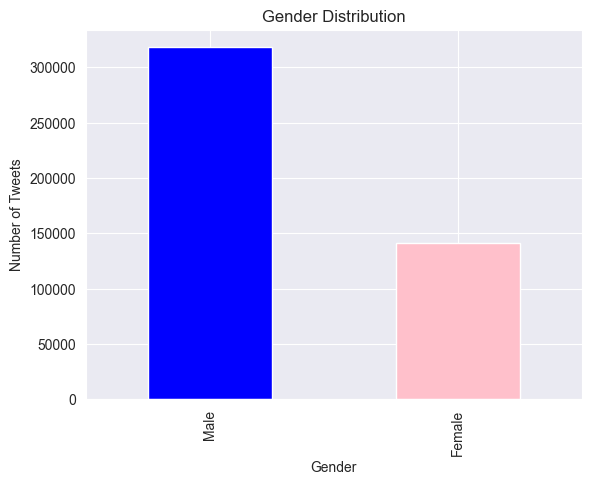

In [35]:

gender_dist = tweets_merged['gender'].str.capitalize().value_counts()

# Gender distribution of these political tweets
gender_dist.plot(kind='bar', color=['blue', 'pink'])
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of Tweets")
plt.show()


There is a strong imbalance in tweet contributions among genders. The overall trend seems to be that men are more engaged in political topics with the number of tweets generated double that of their counterpart.

 ## Age Groups that Tweet about Politics vs. Other Topics

 *We want to compare data sets of political tweets vs. non-political tweets to see how different age groups might engage differently based on the two topics.*


In [36]:
#create data that excludes political tweets
nonpolitical_data = data[~data["text"].str.contains(pattern, case=False, na=False)]

# Merge the user DataFrame into tweets based on 'user_id' and 'id'
nonpolitical_merged = nonpolitical_data.merge(users, left_on='user_id', right_on='id', how='left')

# Drop the redundant 'id' column (since 'user_id' now contains the same information)
nonpolitical_merged.drop(columns=['id'], inplace=True)

# Verify the merge
print(f"Shape of the merged DataFrame: {nonpolitical_merged.shape}")
print(nonpolitical_merged.isnull().any())

C:\Users\linhv\AppData\Local\Temp\ipykernel_14216\276582700.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nonpolitical_data = data[~data["text"].str.contains(pattern, case=False, na=False)]


Shape of the merged DataFrame: (2167584, 13)
tweet_id       False
user_id        False
date           False
text           False
nb_original    False
nb_answer      False
nb_retweet     False
anxiety        False
anger          False
sadness        False
gender         False
age            False
region         False
dtype: bool


We created a new data frame for non-political data and merge them with the users data frame.

In [ ]:
#calculate the percentage of political tweets out of the total tweets based on age group
tweet_fraction = []
for age in users['age'].unique():
    political_age = tweets_merged[tweets_merged['age'] == age].shape[0]
    nonpolitical_age = nonpolitical_merged[nonpolitical_merged['age'] == age].shape[0]
    fraction = political_age / (political_age + nonpolitical_age)
    tweet_fraction.append(fraction)

fraction_data = pd.DataFrame({'age': tweets_merged['age'].unique(), 'fraction': tweet_fraction})

*This code below will generate 4 bar graphs for Age Distribution based on different categories.*

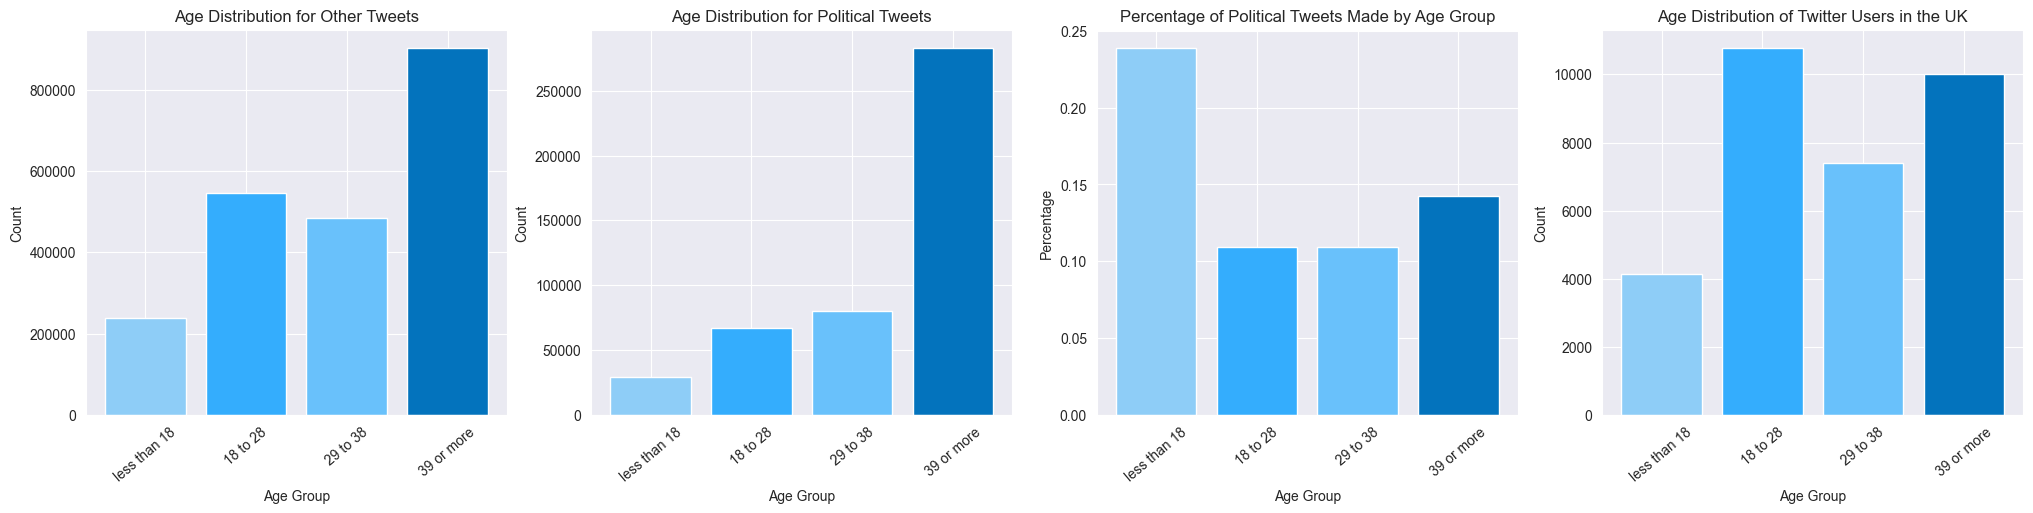

In [ ]:
# Define a consistent color mapping and age group order
color_map = {
    "less than 18": "#8ECDF7",
    "18 to 28": "#34ADFD",
    "29 to 38": "#69C1FB",
    "39 or more": "#0373BD"
}
age_order = ["less than 18", "18 to 28", "29 to 38", "39 or more"]

fig = plt.figure(figsize=(25, 5))

ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)

# Age Distribution for Other Tweets
nonpolitical_counts = nonpolitical_merged['age'].value_counts()
nonpolitical_counts = nonpolitical_counts.reindex(age_order)
ax1.bar(nonpolitical_counts.index, nonpolitical_counts, color=[color_map[x] for x in nonpolitical_counts.index])
ax1.tick_params(axis='x', labelrotation=40)
ax1.set_title("Age Distribution for Other Tweets")
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Count")

# Age Distribution for Political Tweets
political_counts = tweets_merged['age'].value_counts()
political_counts = political_counts.reindex(age_order)
ax2.bar(political_counts.index, political_counts, color=[color_map[x] for x in political_counts.index])
ax2.tick_params(axis='x', labelrotation=40)
ax2.set_title("Age Distribution for Political Tweets")
ax2.set_xlabel("Age Group")
ax2.set_ylabel("Count")

# Percentage of Political Tweets Out of All Tweets Made by Age Group
fraction_data = fraction_data.set_index('age')  # Ensure index alignment
fraction_data = fraction_data.reindex(age_order)
ax3.bar(fraction_data.index, fraction_data['fraction'], color=[color_map[x] for x in fraction_data.index])
ax3.tick_params(axis='x', labelrotation=40)
ax3.set_title("Percentage of Political Tweets Made by Age Group")
ax3.set_xlabel("Age Group")
ax3.set_ylabel("Percentage")

# Age Distribution of Twitter Users in the UK
user_counts = users['age'].value_counts()
user_counts = user_counts.reindex(age_order)
ax4.bar(user_counts.index, user_counts, color=[color_map[x] for x in user_counts.index])
ax4.tick_params(axis='x', labelrotation=40)
ax4.set_title("Age Distribution of Twitter Users in the UK")
ax4.set_xlabel("Age Group")
ax4.set_ylabel("Count")

plt.show()

The first graph highlights how non-politcal tweets are distributed accross different age groups while the second graph is for politcal topics. Overall, people who are 39+ seems to be more engaged with Twitter. We could also see that older age group (29+) appears to be more interested in interacting with polical topics. In addition, roughly 1 out of 4 tweets created by people whose age is 39 or more is about politics! Even though, the most common age group on Twitter is 18 to 28, they seem to not be as interacting as other age group.

### Twitter Users in UK Region
*We want to create a map of Twitter account users using the region data to see if there is any interesting insight we could gain.*


We first need to import geopandas which is designed for working with geographic data. We found a geoJSON file on [Kaggle](https://www.kaggle.com/datasets/dorianlazar/uk-regions-geojson) that maps out geographic data structures of the UK.

In [38]:
import geopandas as gpd

# Load the GeoJSON file into a GeoDataFrame
uk_regions = gpd.read_file(r"C:\Users\linhv\PyCharmMiscProject\data\uk_regions.geojson")

print(uk_regions)

print(uk_regions['rgn19nm'])

    objectid    rgn19cd                   rgn19nm         ctry19nmw   bng_e  \
0          1  E12000001                North East              None  417314   
1          2  E12000002                North West              None  350014   
2          3  E12000003  Yorkshire and the Humber              None  446902   
3          4  E12000004             East Midlands              None  477659   
4          5  E12000005             West Midlands              None  386294   
5          6  E12000006                      East              None  571078   
6          7  E12000007                    London              None  517515   
7          8  E12000008                South East              None  470062   
8          9  E12000009                South West              None  285013   
9         10  N92000002          Northern Ireland  Gogledd Iwerddon   86544   
10        11  S92000003                  Scotland          Yr Alban  277744   
11        12  W92000004                     Wales   

After displaying the content, this file contains columns with id to each region, region name, longitude, latitude, geometry, etc. The name of the column that contains region name is called 'rgn19nm'.

### Which regions seem to care more about politics?


*Merge the number of tweets generated in each region with the uk_regions data set using the region name as the key for both dataframe. First, we create a new dataframe that only contains the number of tweets in each region. We do this by counting values for each region appeared in our political tweet dataframe and convert the result into a new dataframe. Then we resets the index. Next, we perform left join on uk_regions dataframe, meaning that all rows in the uk_regions dataframe are kept. We use 'rgn19nm' column in uk_regions and 'region' in df1 to match rows.*

In [40]:
df1 = tweets_merged['region'].value_counts().to_frame()
df1.reset_index(inplace=True)

#merge two data together
uk_regions = pd.merge(
    left=uk_regions,
    right=df1,
    left_on='rgn19nm',
    right_on='region',
    how='left'
)
uk_regions.drop(columns=['region'], inplace=True)
uk_regions.head()



,objectid,rgn19cd,rgn19nm,ctry19nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,geometry,count_x,count_y
0,1,E12000001,North East,None,417314,600356,-1.72888,55.297009,8.597298e+09,1.032344e+06,"MULTIPOLYGON (((-2.03 55.77, -2.02 55.77, -2.0...",7545,7545
1,2,E12000002,North West,None,350014,506279,-2.77239,54.449440,1.416487e+10,2.387418e+06,"MULTIPOLYGON (((-2.53 55.08, -2.69 55.19, -2.7...",35177,35177
2,3,E12000003,Yorkshire and the Humber,None,446902,448736,-1.28714,53.932640,1.540842e+10,1.392569e+06,"MULTIPOLYGON (((-0.79 54.56, -0.8 54.56, -0.8 ...",36176,36176
3,4,E12000004,East Midlands,None,477659,322635,-0.84969,52.795719,1.564504e+10,1.388752e+06,"MULTIPOLYGON (((-0.3 53.61, -0.31 53.61, -0.3 ...",19018,19018
4,5,E12000005,West Midlands,None,386294,295477,-2.20358,52.556969,1.300374e+10,9.537750e+05,"POLYGON ((-1.96 53.22, -1.98 53.22, -1.98 53.2...",20992,20992


## Choropleth map for the number of political tweets by region in the UK

*We plot the regions from uk_regions GeoDataframe using the number of tweets for coloring the regions.*

Text(0.5, 1.0, 'Number of Political Tweets by Region in the UK')

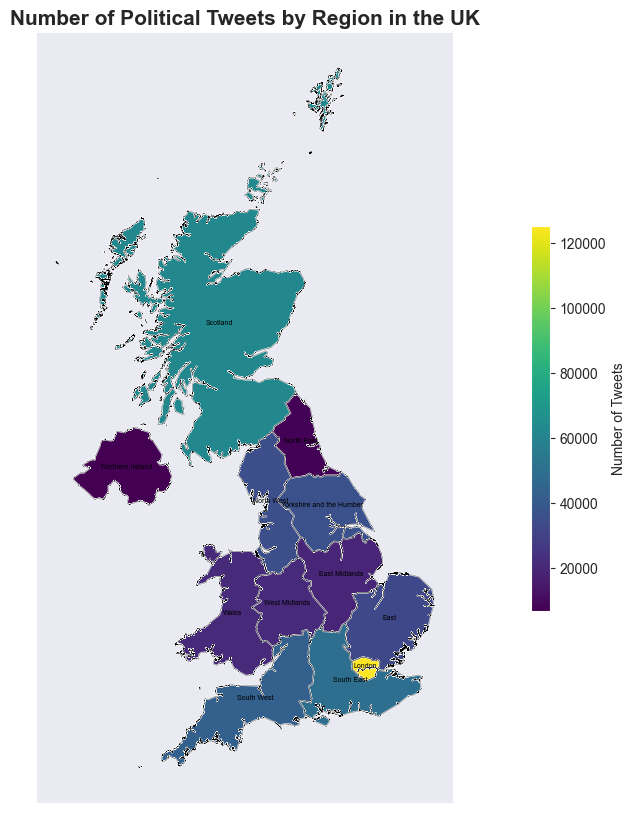

In [41]:
#plot choropleth map for the number of political tweets by region in the UK
#show the boundary line in black and line width is 0.2
ax = uk_regions.boundary.plot(edgecolor='black', linewidth=0.2, figsize=(20,10))

#show legend, shrink it by half and label it
uk_regions.plot(ax=ax, column='count_x',
                legend=True,
                legend_kwds={
    'shrink': 0.5,
    'label': 'Number of Tweets'},
                cmap='viridis')

#remove the x and y axis values
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#remove the map frame
for edge in ['right', 'bottom', 'top', 'left']:
    ax.spines[edge].set_visible(False)
# Add region names as annotations on the map
# Iterate through each region
for _, row in uk_regions.iterrows():
    # Plot region name at the centroid of the region
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y,  # centroid coordinates (x, y)
             row['rgn19nm'],
             fontsize=5, ha='center', color='black')  # adjust fontsize, alignment, and color
#add title
ax.set_title('Number of Political Tweets by Region in the UK', size=15, weight='bold')


From the map, it is obvious that London has the highest volume of political tweets. This might suggests Londoners are highly engaged in political discussions. However, we also have to keep in mind of the imbalance in population in each of these regions. If we can normalize the data by population, we can understand whether high number of tweets is due to population density or greater political engagement. Therefore, to make a final conclusion we will need further analysis.

Middle regions like East/West Midlands, Wales and Northern Ireland seems to be less engaging with political topics. However, another limitation of this is we are only looking at Twitter users, and maybe the people from these regions engage in politics from different platforms.


# Cleaning Bonds
### Adding weekend data

*First we check the date range of our data:*

In [42]:
# Checking date range in our data

print(bonds, '\n')

print(tweets_raw['date'].min(), tweets_raw['date'].max())

          date    10y
0   2022-10-12  4.417
1   2022-10-13  4.192
2   2022-10-14  4.388
3   2022-10-17  3.974
4   2022-10-18  3.948
5   2022-10-19  3.877
6   2022-10-20  3.910
7   2022-10-21  4.050
8   2022-10-24  3.740
9   2022-10-25  3.631
10  2022-10-26  3.575
11  2022-10-27  3.408
12  2022-10-28  3.471
13  2022-10-31  3.510
14  2022-11-01  3.464 

2022-10-12 00:00:02 2022-10-31 00:00:00


Our bond data ranges from October 12 to Nov 01 (assuming that the bond yield is recorded right before the market closes on that day) while Our tweets data is from October 12 at 12:02 a.m. to October 31 at 12:00 a.m.

*Change values in bonds date column to date time*

In [43]:
bonds['date'] = pd.to_datetime(bonds['date'])

*Then we add weekends, preserving the friday values:*

In [44]:
#create new data frame consisting of missing weekend date and interest rate. The interest rate is assumed to stay the same
#when the market closes on the weekend

date = ['2022-10-15', '2022-10-16', '2022-10-22', '2022-10-23', '2022-10-29', '2022-10-30']
interest = [4.388, 4.388, 4.050, 4.050, 3.471, 3.471]
new_data = pd.DataFrame({'date': date, '10y': interest})

#concatenate new data to the bonds data
bonds = pd.concat([bonds, new_data], ignore_index=True)

#convert date to datetime
bonds['date'] = pd.to_datetime(bonds['date'])

#sort values based on date
bonds.sort_values(by=['date'], inplace=True)

print(bonds)

         date    10y
0  2022-10-12  4.417
1  2022-10-13  4.192
2  2022-10-14  4.388
15 2022-10-15  4.388
16 2022-10-16  4.388
3  2022-10-17  3.974
4  2022-10-18  3.948
5  2022-10-19  3.877
6  2022-10-20  3.910
7  2022-10-21  4.050
17 2022-10-22  4.050
18 2022-10-23  4.050
8  2022-10-24  3.740
9  2022-10-25  3.631
10 2022-10-26  3.575
11 2022-10-27  3.408
12 2022-10-28  3.471
19 2022-10-29  3.471
20 2022-10-30  3.471
13 2022-10-31  3.510
14 2022-11-01  3.464


The output shows that bonds dataframe is updated to include the bond rate for everyday.

*We are going to filter out the bond rates on October 31st and November 1st to have consistent date between the bonds dataframe and the tweets dataframes.*

In [45]:
# Filter out rows where the date is October 31st and Nov 1st
bonds = bonds[bonds['date'].dt.date != pd.Timestamp('2022-10-31').date()]
bonds = bonds[bonds['date'].dt.date != pd.Timestamp('2022-11-01').date()]

# Bond descriptives

*This code will generate descriptive statistics for the bondyields*

In [46]:
# Descriptive statistics for bond yields
bond_stats = bonds['10y'].describe()
print("Descriptive Statistics for Bond Yields:")
print(bond_stats)

# Additional statistics: range, variance, standard deviation
bond_range = bonds['10y'].max() - bonds['10y'].min()
print(f"Range of Bond Yields: {bond_range:.3f}")
print(f"Variance: {bonds['10y'].var():.3f}")
print(f"Standard Deviation: {bonds['10y'].std():.3f}")

Descriptive Statistics for Bond Yields:
count    19.000000
mean      3.915737
std       0.344477
min       3.408000
25%       3.603000
50%       3.948000
75%       4.121000
max       4.417000
Name: 10y, dtype: float64
Range of Bond Yields: 1.009
Variance: 0.119
Standard Deviation: 0.344


The ouput shows the descriptive statistics for the bonds yields. On average, the bond yield is at 3.9% and the minimum is 3.4% while the max is 4.4%.

*This code below will generate a time series plot for the soveraign bond yield.*

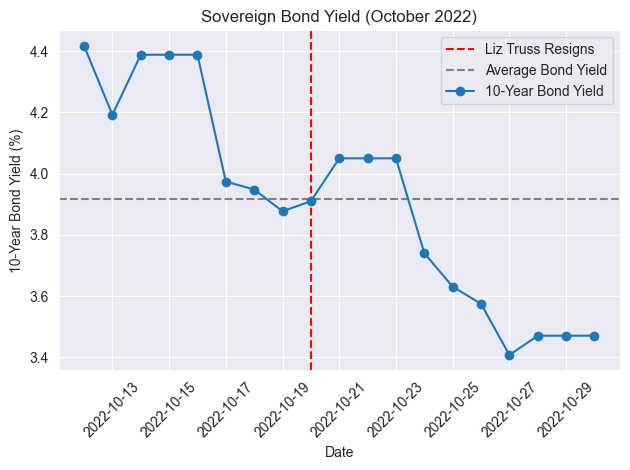

In [47]:
# Plot of bond yields over time
import matplotlib.pyplot as plt

# Add a line on October 22, 2022
line_date = pd.to_datetime('2022-10-20')
plt.axvline(x=line_date, color='red', linestyle='--', label='Liz Truss Resigns')
line_yield = 3.915737
plt.axhline(y=line_yield, color='grey', linestyle='--', label='Average Bond Yield')

# plt.figure(figsize=(10, 6))
plt.plot(bonds['date'], bonds['10y'], marker='o', linestyle='-', label='10-Year Bond Yield')
plt.title('Sovereign Bond Yield (October 2022)')
plt.xlabel('Date')
plt.ylabel('10-Year Bond Yield (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The graph shows the 10-year sovereign bond yield for October 2022, highlighting the date of Liz Truss's resignation as UK Prime Minister (marked with a red dashed line). Before Liz Truss's resignation (October 19, 2022), the bond yield was relatively high, peaking around 4.4% but after her resignation, the yield begins to decline steadily, eventually stabilizing around 3.4%. The average yield is also provided to help observe the trend.


The decrease in sovereign bond yields can be explained by the influence of economic stability and market confidence. Liz Truss's government faced criticism for its fiscal policies and her resignation likely regained some market confidence as investors expected a reversal of these policies.

# New Variables

*We create a new dataframe by grouping the values for sadness, anger and anciety by date and then calculate the mean for each using pd.Grouper function. key='date' indicates the 'date' column is used for grouping and freq='D' indicates that the grouping is done daily.*

In [48]:
# Group by date and calculate the mean for 'sadness', 'anger', and 'anxiety'
daily_sentiment_data = political_data.groupby(pd.Grouper(key='date', freq='D'))[['sadness', 'anger', 'anxiety']].mean().reset_index()

# Display the result
print(daily_sentiment_data.head())

        date   sadness     anger   anxiety
0 2022-10-12  0.007829  0.013452  0.005579
1 2022-10-13  0.007187  0.012979  0.005262
2 2022-10-14  0.011158  0.012187  0.004656
3 2022-10-15  0.009632  0.014998  0.005875
4 2022-10-16  0.008043  0.013810  0.005025


*We created a new column called 'negative emotionality' that contains the average score of these three emotions for each day. The parameter axis=1 indicates that the mean is calculated across columns.*


In [49]:
# Calculate average negative emotionality
daily_sentiment_data['negative_emotionality'] = daily_sentiment_data[['sadness', 'anger', 'anxiety']].mean(axis=1)

# Display the updated DataFrame
print(daily_sentiment_data.head())


        date   sadness     anger   anxiety  negative_emotionality
0 2022-10-12  0.007829  0.013452  0.005579               0.008953
1 2022-10-13  0.007187  0.012979  0.005262               0.008476
2 2022-10-14  0.011158  0.012187  0.004656               0.009334
3 2022-10-15  0.009632  0.014998  0.005875               0.010169
4 2022-10-16  0.008043  0.013810  0.005025               0.008959



 After running this code, the dataframe will have one more column recording the average score of 3 emotions on each date.


*This code below help us find the number of retweets for each text. We group the dataset by the 'text' column so that all rows with the same text are treated as a single group. Then we sum up the nb_retweet column for each group.*


In [50]:
# Group by 'text' and sum the 'nb_retweet' column
retweet_counts = political_data.groupby('text', as_index=False)['nb_retweet'].sum()

# Renaming the column for clarity
retweet_counts.rename(columns={'nb_retweet': 'num_retweets'}, inplace=True)

# Display the top 10 texts with the most retweets
print("Top 10 tweets with their retweet counts:")
print(retweet_counts.sort_values(by='num_retweets', ascending=False).head(10))

Top 10 tweets with their retweet counts:
                                                     text  num_retweets
153589  rt @bydonkeys: a historic failure https://t.co...         686.0
141513  rt @alan_mcguinness: my son has lived through ...         538.0
206960  rt @number10cat: “the king has asked me to bec...         429.0
153601  rt @bydonkeys: let's take a closer look at the...         416.0
159774  rt @dailystar: breaking news:\n\n🚨 the lettuce...         374.0
173660  rt @georgemonbiot: sorry to repeat myself, but...         349.0
227501  rt @stephenfry: no @borisjohnson no no no no n...         312.0
154095  rt @campbellclaret: general. election. now. or...         294.0
150886  rt @bmay: truss: “your majesty… lovely to see ...         289.0
221515  rt @sathnam: retweet if you want a bloody gene...         276.0


The output displayes the top 10 most retweeted tweets and their respective counts. It's useful for identifying the most popular tweets within a dataset.


# Data Visualization

*The code will create a time-series plot showing trends in sadness, anger, and anxiety over a specific time period (October 2022).
The vertical red dashed line marks October 20, 2022, labeled as "Liz Truss Resigns".
The x-axis will display the dates, and the y-axis represents the intensity of emotions scaled from 0 to 1.*

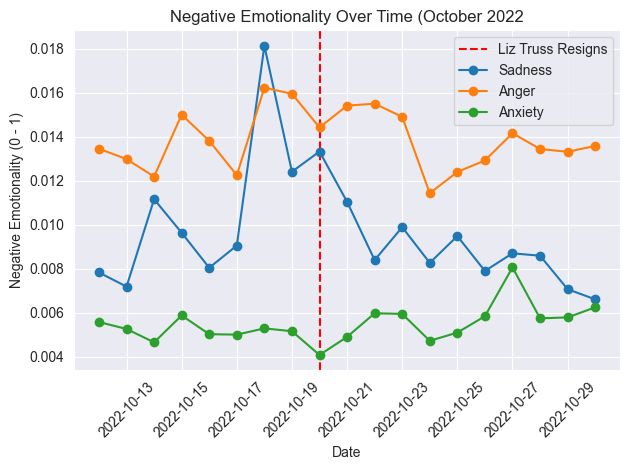

In [51]:
# Add a line on October 22, 2022
line_date = pd.to_datetime('2022-10-20')
plt.axvline(x=line_date, color='red', linestyle='--', label='Liz Truss Resigns')

# plt.figure(figsize=(10, 6))
plt.plot(daily_sentiment_data['date'], daily_sentiment_data['sadness'], marker='o', linestyle='-', label='Sadness')
plt.plot(daily_sentiment_data['date'], daily_sentiment_data['anger'], marker='o', linestyle='-', label='Anger')
plt.plot(daily_sentiment_data['date'], daily_sentiment_data['anxiety'], marker='o', linestyle='-', label='Anxiety')
plt.title('Negative Emotionality Over Time (October 2022')
plt.xlabel('Date')
plt.ylabel('Negative Emotionality (0 - 1)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The graph shows that anger and sadness spike sharply around October 17, just before the resignation, likely reflecting public dissatisfaction with the new fiscal policies. After resignation, both emotions show noticeable declines, meaning there is a reduction in public negativity as political uncertainty eases.

However, anxiety remains stable and relatively low, suggesting persistent concerns about the economic or political situation.

Overall, the resignation appears to improve some anger and sadness, as seen in their subsequent declines while anxiety is still lingering.

*The code will create a time-series plot showing trend in the average negative emotions over a specific time period (October 2022).
The vertical red dashed line marks October 20, 2022, labeled as "Liz Truss Resigns".
The x-axis will display the dates, and the y-axis represents the intensity of emotions scaled from 0 to 1.*

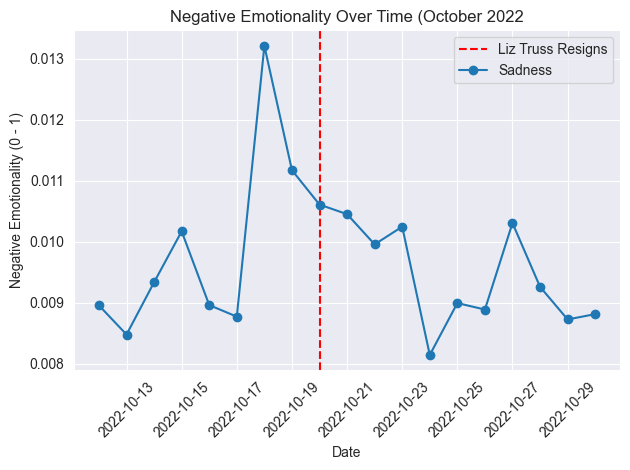

In [53]:
# Add a line on October 22, 2022
line_date = pd.to_datetime('2022-10-20')
plt.axvline(x=line_date, color='red', linestyle='--', label='Liz Truss Resigns')

# plt.figure(figsize=(10, 6))
plt.plot(daily_sentiment_data['date'], daily_sentiment_data['negative_emotionality'], marker='o', linestyle='-', label='Sadness')
plt.title('Negative Emotionality Over Time (October 2022')
plt.xlabel('Date')
plt.ylabel('Negative Emotionality (0 - 1)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Overall, this graph shows that the average negative emotion also peeks sharply around October 17, just before the resignation and noticeably declines after the resignation.


## Plot tweets per day

*This code visualizes the daily number of tweets from the dataset and includes a reference line for when Liz resigns on October 20th, 2022.*


        date  tweet_id
0 2022-10-12    129007
1 2022-10-13    124810
2 2022-10-14    153387
3 2022-10-15    132070
4 2022-10-16    135969


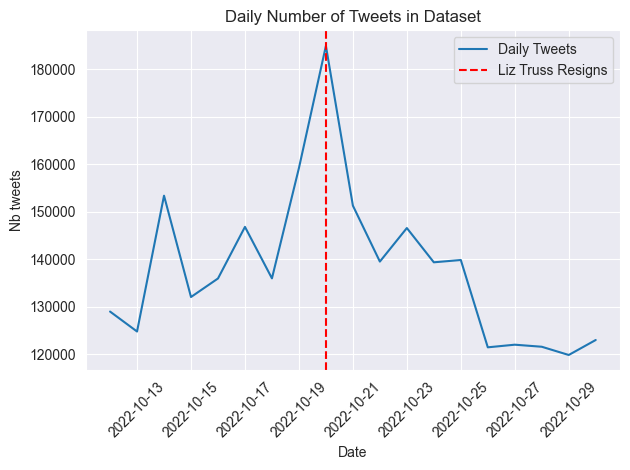

In [54]:
import matplotlib.pyplot as plt

cols = ['date', 'tweet_id']
daily_data = data[cols].groupby(pd.Grouper(key='date', freq='D')).count().reset_index()
print(daily_data.head())

fig = plt.figure()

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(daily_data['date'], daily_data['tweet_id'])
ax1.set_title('Daily Number of Tweets in Dataset')
ax1.set_xlabel('Date')
ax1.set_ylabel('Nb tweets')
ax1.tick_params(axis='x', rotation=45)

# add a line on october 20th
ax1.axvline(x=pd.Timestamp('2022-10-20').date(), color='red', linestyle='--')

# Legend
ax1.legend(['Daily Tweets', 'Liz Truss Resigns'])

plt.tight_layout()
plt.show()

The graph shows that the number of tweets increases significantly and reaches the peak the date that Liz resigns.


## Plot standardized Anxiety, Number of Tweets, and 10y Bond Yield

# Sentiment Analysis

*The code processes the tweets in political data by collecting the tweets into a list and remove URLs from the tweets. Then it combines the cleaned tweets into a single string and removes special characters/symbols from this combined string.*

In [55]:
a = []
for tweet in political_data['text']:
    a.append(tweet)

b = [re.sub(r'http\S+', '', tweet) for tweet in a]

flat =' '.join(b)

pattern = r'["#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~$€£¥₹₽₩₦฿₺₪]'
x = re.sub(pattern, '', flat)

*This code iterate through a collection and clean strings by removing unwanted patterns. Then it breaks a string down into tokens using .split() and appending the results to the empty list created in the beginning.*


In [56]:
tokenized_tweets = []
for text in b:
  text = re.sub(pattern, '', text)
  tokenized_tweets.append(text.split())

*The 'join' method builds a single string from the flattened list, with spaces separating the words.*

In [57]:
token_flat = ' '.join(word for tweet in tokenized_tweets for word in tweet)

The result is a single string where all tweet tokens are combined into one, maintaining their original order.


*This code creates an instance of the TextBlob class by passing the text stored in token_flat to it, which can be used to analyze the text stored in the token_flat variable.*

In [61]:
blob_text = TextBlob(token_flat)

*The code evaluates the sentiment polarity of textual data in the 'text' column of 'political_data'.
It processes each text entry using the 'calculate_polarity' function to calculate the polarity scores which are stored in a new dataframe column, 'polarity'.*

In [62]:
def calculate_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply the function to the 'text' column
political_data['polarity'] = political_data['text'].apply(calculate_polarity)

# Display the first few rows with polarity
print(political_data[['text', 'polarity']].head())


                                                 text  polarity
32  rt @bill_esterson: the conservatives crashed t... -0.600000
39  rt @bootstrapcook: being a tory is not a prote... -0.066667
52                              @joeywreck democracy.  0.000000
58  rt @jeremyclarkson: @hcgacio @mrjkilcoyne @tru...  0.000000
86  @streborhg 1 - whatever a government elected s... -0.333333


C:\Users\linhv\AppData\Local\Temp\ipykernel_14216\2134035626.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_data['polarity'] = political_data['text'].apply(calculate_polarity)


*This code group data by the 'date' column, aggregating rows into one for each day, and calculate the mean of the polarity values.*

In [63]:
# Group by date and calculate the mean for 'sadness', 'anger', and 'anxiety'
daily_sentiment_data2 = political_data.groupby(pd.Grouper(key='date', freq='D'))[['polarity']].mean().reset_index()

# Display the result
print(daily_sentiment_data2.head())

        date  polarity
0 2022-10-12  0.030820
1 2022-10-13  0.051198
2 2022-10-14  0.041747
3 2022-10-15  0.052147
4 2022-10-16  0.050995


It produces a new DataFrame that contains the daily average polarity, with each row representing one day

*The following code plots the average daily polarity in October, with a red line indicating when Lizz Truss resigned for reference.*

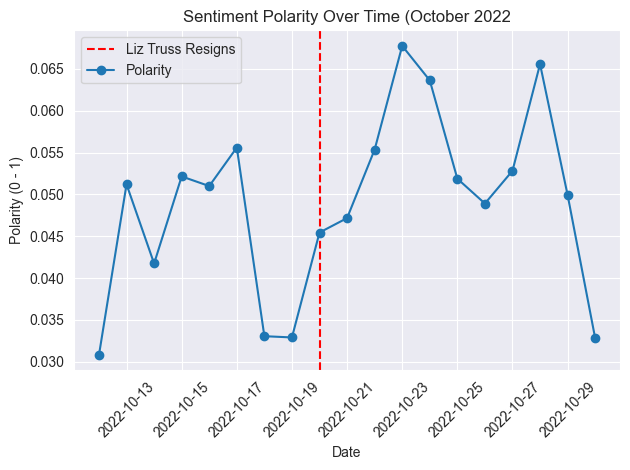

In [64]:
plt.show()
# Add a line on October 22, 2022
line_date = pd.to_datetime('2022-10-20')
plt.axvline(x=line_date, color='red', linestyle='--', label='Liz Truss Resigns')

# plt.figure(figsize=(10, 6))
plt.plot(daily_sentiment_data2['date'], daily_sentiment_data2['polarity'], marker='o', linestyle='-',
         label='Polarity')
plt.title('Sentiment Polarity Over Time (October 2022')
plt.xlabel('Date')
plt.ylabel('Polarity (0 - 1)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The output is a plot of daily sentiment in October. It is clear that sentiment has a very high variance on a daily basis, with a small range of values indicating that it may not be significant in this context.

*The code below standardizes the anxiety, daily tweet, and bond yield data. This is because these are three variables we observed to have signficant relationship, but they are on different scales. For correlation it does not matter, but for data visualization it will help with interpretation. First, we merge the relevent data, and then standardize.*

In [65]:
std_data = pd.merge(daily_sentiment_data, daily_sentiment_data2, on='date', how='inner')
bonds['date'] = pd.to_datetime(bonds['date'])
std_data = pd.merge(std_data, bonds, on='date', how='inner')
std_data = pd.merge(std_data, daily_data, on='date', how='inner')

In [66]:
# Initialize a scaler
scaler = StandardScaler()

std_data = std_data[['date', 'anxiety', 'tweet_id', '10y']]

columns_to_standardize = ['anxiety', 'tweet_id', '10y']
standardized_data = scaler.fit_transform(std_data[columns_to_standardize])
std_data[['anxiety_std', 'num_tweets_std', '10y_std']] = standardized_data

*The code below graphs standardized anxiety*

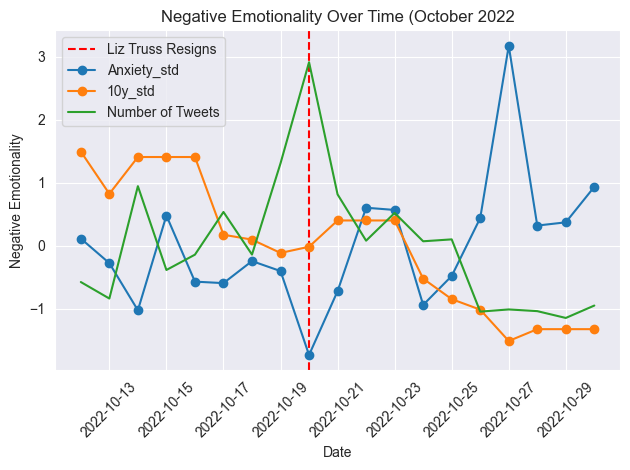

In [67]:
# Add a line on October 22, 2022
line_date = pd.to_datetime('2022-10-20')
plt.axvline(x=line_date, color='red', linestyle='--', label='Liz Truss Resigns')

# plt.figure(figsize=(10, 6))
plt.plot(std_data['date'], std_data['anxiety_std'], marker='o', linestyle='-', label='Anxiety_std')
plt.plot(std_data['date'], std_data['10y_std'], marker='o', linestyle='-', label='10y_std')
plt.plot(std_data['date'], std_data['num_tweets_std'], label='Number of Tweets')
plt.title('Negative Emotionality Over Time (October 2022')
plt.xlabel('Date')
plt.ylabel('Negative Emotionality')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The result is a graph that shows our variables of interest and how they change over time in October. Notice the drastic changes around October 20th.

# Correlations

*The code below merges the daily sentiment data (the emotions) with the second daily sentiment data set (the actual sentiment analyis with the polarity). Then, it merges with the bonds data. Both merges are one the 'date' variable to ensure daily data.*

In [68]:
corr_data = pd.merge(daily_sentiment_data, daily_sentiment_data2, on='date', how='inner')
corr_data = pd.merge(corr_data, bonds, on='date', how='inner')

*corr() is used to calculate the correlation between the emotions, the aggregated negative emotionality variable, and sentiment polarity, with the 10 year bond yield. Then, only the data we are looking for is extracted (correlation with bond yield), and the results are printed.*

In [69]:
# Calculate correlations between emotions and sovereign bond yield
correlation_matrix = corr_data[['sadness', 'anger', 'anxiety', 'negative_emotionality', 'polarity', '10y']].corr()

# Extract correlations of bond yield ('10y') with emotions
correlation_with_bond_yield = correlation_matrix['10y'].drop('10y')

# Display the correlation values
print("Correlation between emotions and sovereign bond yield:")
print(correlation_with_bond_yield)

Correlation between emotions and sovereign bond yield:
sadness                  0.168683
anger                    0.154757
anxiety                 -0.421696
negative_emotionality    0.089073
polarity                -0.173649
Name: 10y, dtype: float64


The output includes the correlation coefficients between the variables of interest with 10 year bond yield. As expected a moderate correlation exists between anxiety and bond yield, which is what we predicted based on the descriptive statistics that showed this relationship. Also as expected, weak correlations were found between the other variables and bond yield. However, research has shown that political uncertainty tends to be positively correlated with bond yield, so a negative relationship is surprising.

*The code below creates scatter plots showing the relationships indicated by the above correlations.*

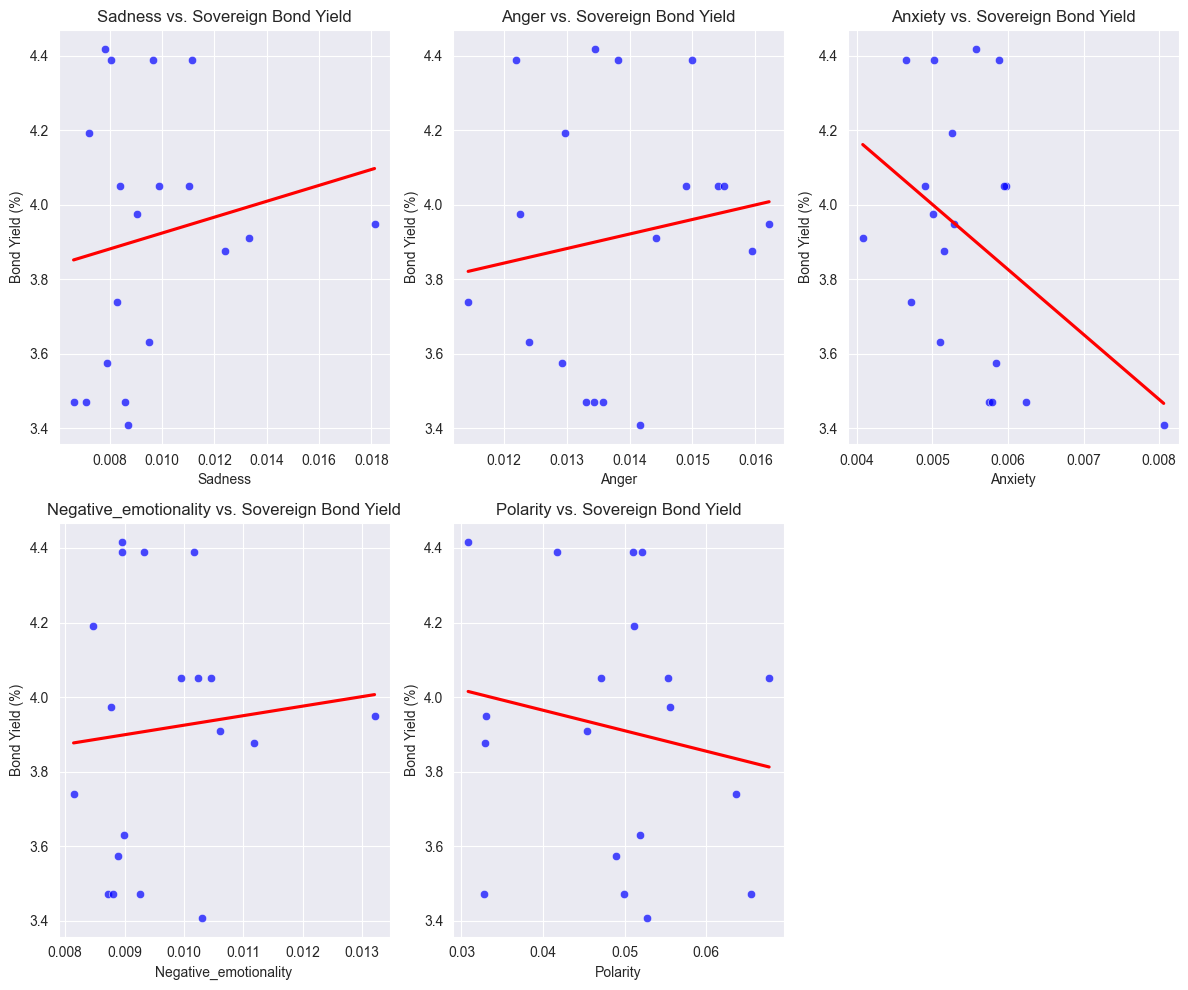

In [70]:
# Create scatterplots for each emotion vs. bond yields
emotions = ['sadness', 'anger', 'anxiety', 'negative_emotionality', 'polarity']

# Set up the plotting grid
plt.figure(figsize=(12, 10))
for i, emotion in enumerate(emotions, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=corr_data, x=emotion, y='10y', color='blue', alpha=0.7)
    sns.regplot(data=corr_data, x=emotion, y='10y', scatter=False, color='red', ci=None)  # Add regression line
    plt.title(f"{emotion.capitalize()} vs. Sovereign Bond Yield")
    plt.xlabel(emotion.capitalize())
    plt.ylabel("Bond Yield (%)")
    plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()


The output is 5 scatter plots for each variables relationship with bond yield. This makes it clear that even when looking at the anxiety variable, the results should be takne with a grain of salt, as the data is hardly represented by a linear relationship.

*The code below repeats the process from earlier that creates scatter plots, however we narrow down the dates to dates closer to Liz Truss's resignation on October 20th.*

         date   sadness     anger   anxiety  negative_emotionality  polarity  \
6  2022-10-18  0.018125  0.016220  0.005289               0.013211  0.033065   
7  2022-10-19  0.012406  0.015950  0.005160               0.011172  0.032915   
8  2022-10-20  0.013324  0.014418  0.004080               0.010607  0.045446   
9  2022-10-21  0.011041  0.015409  0.004902               0.010451  0.047170   
10 2022-10-22  0.008393  0.015497  0.005976               0.009955  0.055353   

      10y  
6   3.948  
7   3.877  
8   3.910  
9   4.050  
10  4.050  


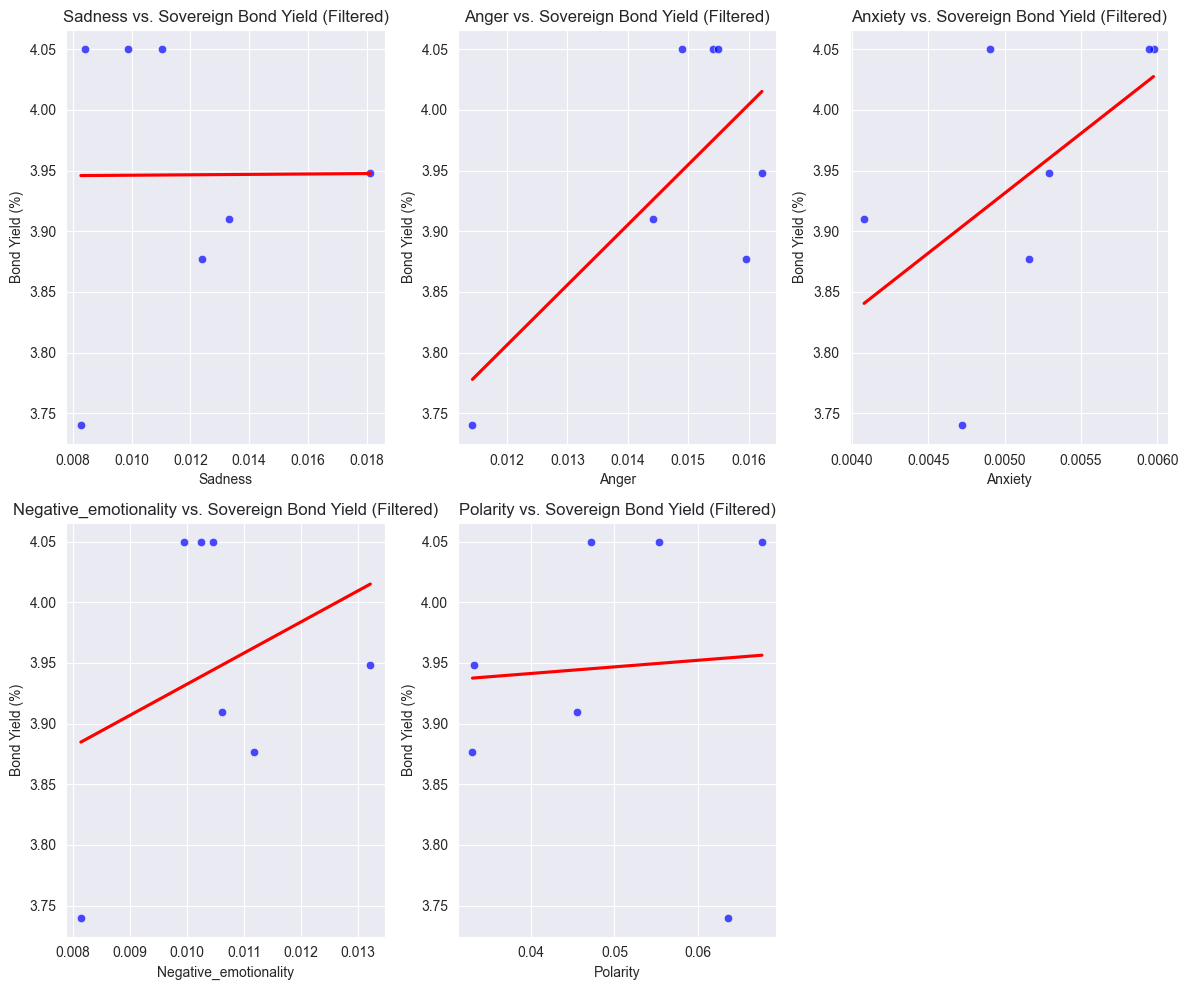

In [71]:
# Define the date range (e.g., 5 days before and after October 20)
start_date = '2022-10-18'
end_date = '2022-10-24'

# Filter the corr_data for the specified date range
filtered_data = corr_data[(corr_data['date'] >= start_date) & (corr_data['date'] <= end_date)]

# Display the filtered data
print(filtered_data.head())

# List of emotions to visualize
emotions = ['sadness', 'anger', 'anxiety', 'negative_emotionality', 'polarity']

# Set up the plotting grid
plt.figure(figsize=(12, 10))
for i, emotion in enumerate(emotions, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=filtered_data, x=emotion, y='10y', color='blue', alpha=0.7)
    sns.regplot(data=filtered_data, x=emotion, y='10y', scatter=False, color='red', ci=None)  # Add regression line
    plt.title(f"{emotion.capitalize()} vs. Sovereign Bond Yield (Filtered)")
    plt.xlabel(emotion.capitalize())
    plt.ylabel("Bond Yield (%)")
    plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()


The results indicate that while the relationships are still not quite represented linearly, it does seem to approach a more linear relationship when the dates are narrowed down. Additionally, the anxiety variable now exhibits a positive relationship with bond yield, which is more in line with research. This indicates that, of course, bond yield is mutltifaceted, and political climate is not the only possible predictor of bond yield. However, when we narrow downt the data to dates closer to political event, we do see that anxiety exhibits the expected relationship with bond yield. Thus, during political turmoil, the importance of political uncertainty increases.

## Final Results

*Below, we once again create a correlation matrix, this time using only the data we believe to be associated with bond yield (based on the descriptive statistics)—Thus, we correlated anxiety with bond yield, and the number of tweets with bond yield. We did this using the narrowed down dates to highlight the political turmoil at the time.*

In [72]:
# Define the date range (e.g., 5 days before and after October 20)
start_date = '2022-10-15'
end_date = '2022-10-25'

# Filter the corr_data for the specified date range
filtered_data = std_data[(std_data['date'] >= start_date) & (std_data['date'] <= end_date)]

In [73]:
# Calculate correlations between emotions and sovereign bond yield
correlation_matrix = filtered_data[['tweet_id', 'anxiety', '10y']].corr()

# Extract correlations of bond yield ('10y') with emotions
correlation_with_bond_yield = correlation_matrix['10y'].drop('10y')

# Create a nicer DataFrame for display
correlation_df = pd.DataFrame(correlation_with_bond_yield).reset_index()
correlation_df.columns = ['Variable', 'Correlation with 10-Year Yield']

# Sort the DataFrame for better readability
correlation_df = correlation_df.sort_values(by='Correlation with 10-Year Yield')

# Display the correlation DataFrame
print(correlation_df)

   Variable  Correlation with 10-Year Yield
0  tweet_id                       -0.287285
1   anxiety                        0.393789


The output shows, as predicted, that both anxiety and number of tweets (represented by tweet_id) have a moderate correlation with bond yield.

*Our final block of code below creates two scatter plots of the variables we belive have the strongest associations with bond yield: anxiety, and number of tweets per day.*